In [1]:
import os
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
import functools
from statsmodels.tsa.stattools import adfuller

**Reading and Preprocessing Crypto Trade Data**

Loaded file: 20250524.parquet , in folder: Binance , with 2090724  trade rows


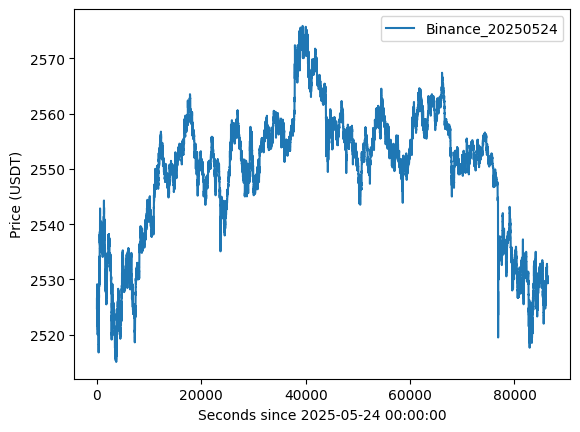

Loaded file: 20250525.parquet , in folder: Binance , with 2556052  trade rows


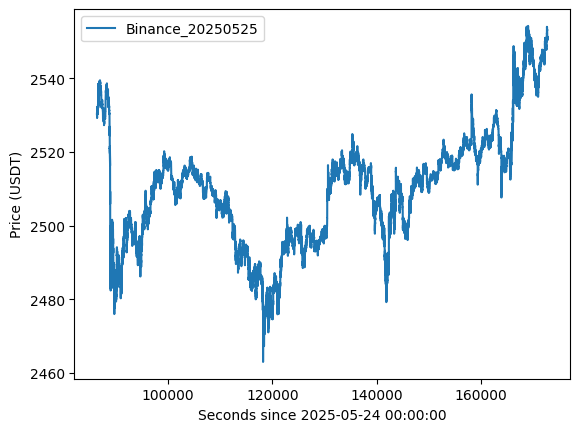

Loaded file: 20250526.parquet , in folder: Binance , with 2374458  trade rows


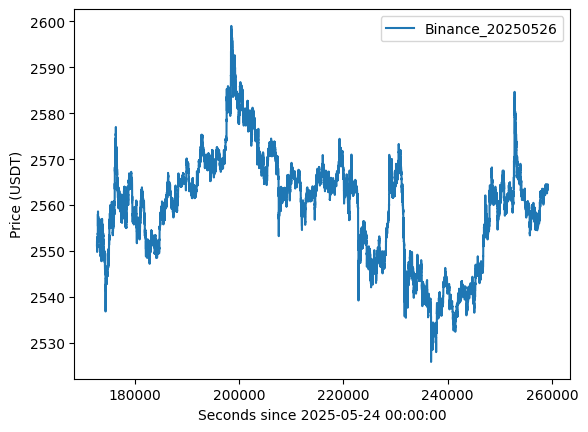

Loaded file: 20250524.parquet , in folder: Coinbase , with 8550  trade rows


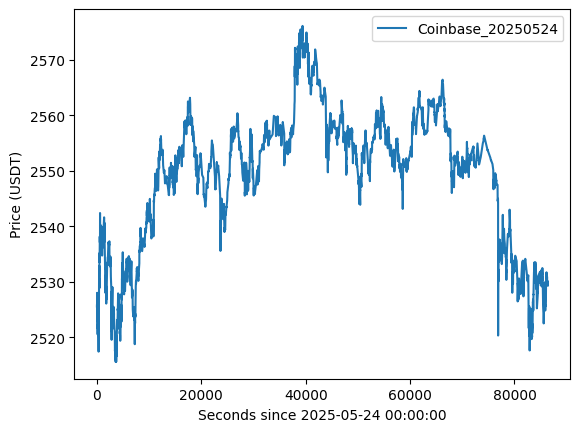

Loaded file: 20250525.parquet , in folder: Coinbase , with 12981  trade rows


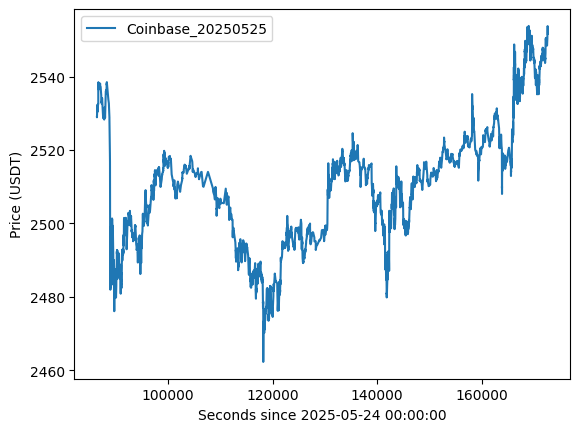

Loaded file: 20250524.parquet , in folder: OKX , with 286466  trade rows


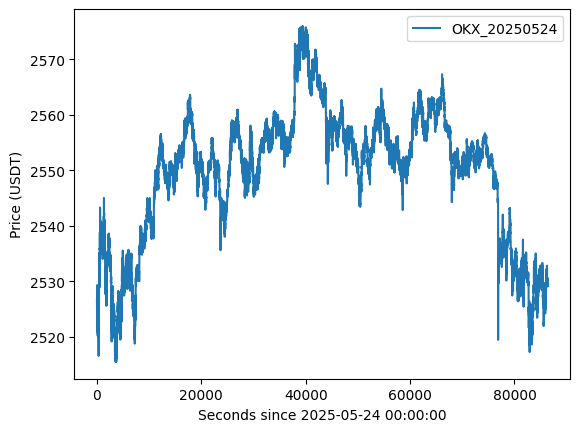

Loaded file: 20250525.parquet , in folder: OKX , with 297363  trade rows


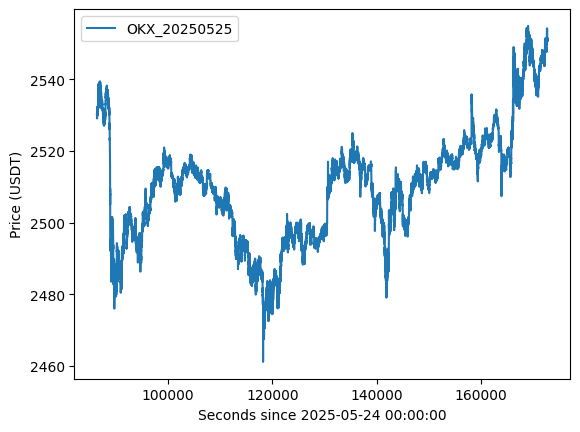

Loaded file: 20250526.parquet , in folder: OKX , with 286596  trade rows


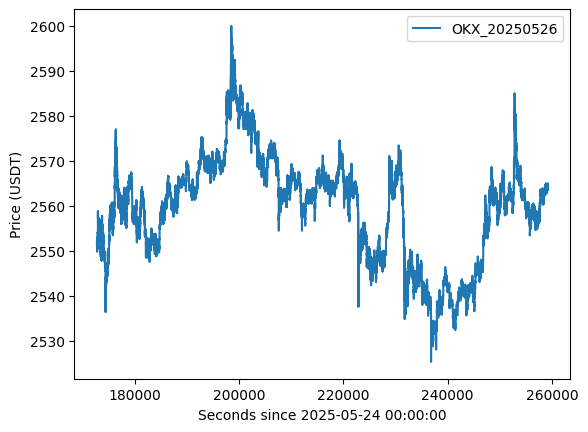

In [2]:
# %matplotlib ipympl

# Read crypto data from parquet files
input_path = r'data/ETH-USDT'

data_dict = {}

start_time = pd.to_datetime('2025-05-24 00:00:00')

for folder in os.listdir(input_path):
    for file in os.listdir(os.path.join(input_path, folder)):
        if file.endswith('.parquet'):
            file_path = os.path.join(input_path, folder, file)
            df = pd.read_parquet(file_path)

            df = df.loc[df['rec_type']=='T']

            print('Loaded file:', file, ', in folder:', folder, ', with', len(df), ' trade rows')

            # df['seconds'] = df['ts'].dt.hour * 3600 + df['ts'].dt.minute * 60 + df['ts'].dt.second
            df['seconds'] = (df['ts'] - start_time).dt.total_seconds().astype(int)
            df['date'] = df['ts'].dt.date

            plt.plot(df['seconds'], df['price'], label=f'{folder}_{file[:-8]}')
            plt.xlabel('Seconds since ' + str(start_time))
            plt.ylabel('Price (USDT)')
            plt.legend()
            plt.show()

            df.drop(['ts','rec_type','side','qty'], axis=1, inplace=True)
            df.rename(columns={'price':folder}, inplace=True)
            df = df.groupby('seconds').tail(1).reset_index(drop=True)

            data_dict.setdefault(folder, []).append(df)

for folder, df_list in data_dict.items():
    data_dict[folder] = pd.concat(df_list, sort=False).reset_index(drop=True)

**Second level Comparison Plot**

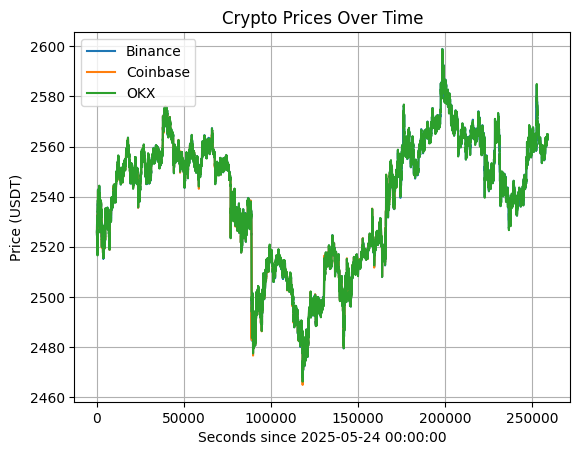

In [3]:
for folder, df_list in data_dict.items():
    plt.plot(data_dict[folder]['seconds'], data_dict[folder][folder], label=folder)
plt.xlabel('Seconds since ' + str(start_time))
plt.ylabel('Price (USDT)')
plt.title('Crypto Prices Over Time')
plt.legend()
plt.grid()
plt.show()

**Number of seconds with trade data per day for each exchange**

In [4]:
data_dict['Binance'].groupby('date').size()

date
2025-05-24    69555
2025-05-25    70947
2025-05-26    72372
dtype: int64

In [5]:
data_dict['Coinbase'].groupby('date').size()

date
2025-05-24    2657
2025-05-25    3017
dtype: int64

In [6]:
data_dict['OKX'].groupby('date').size()

date
2025-05-24    46079
2025-05-25    48911
2025-05-26    48434
dtype: int64

**Spreads Computation and Analysis**

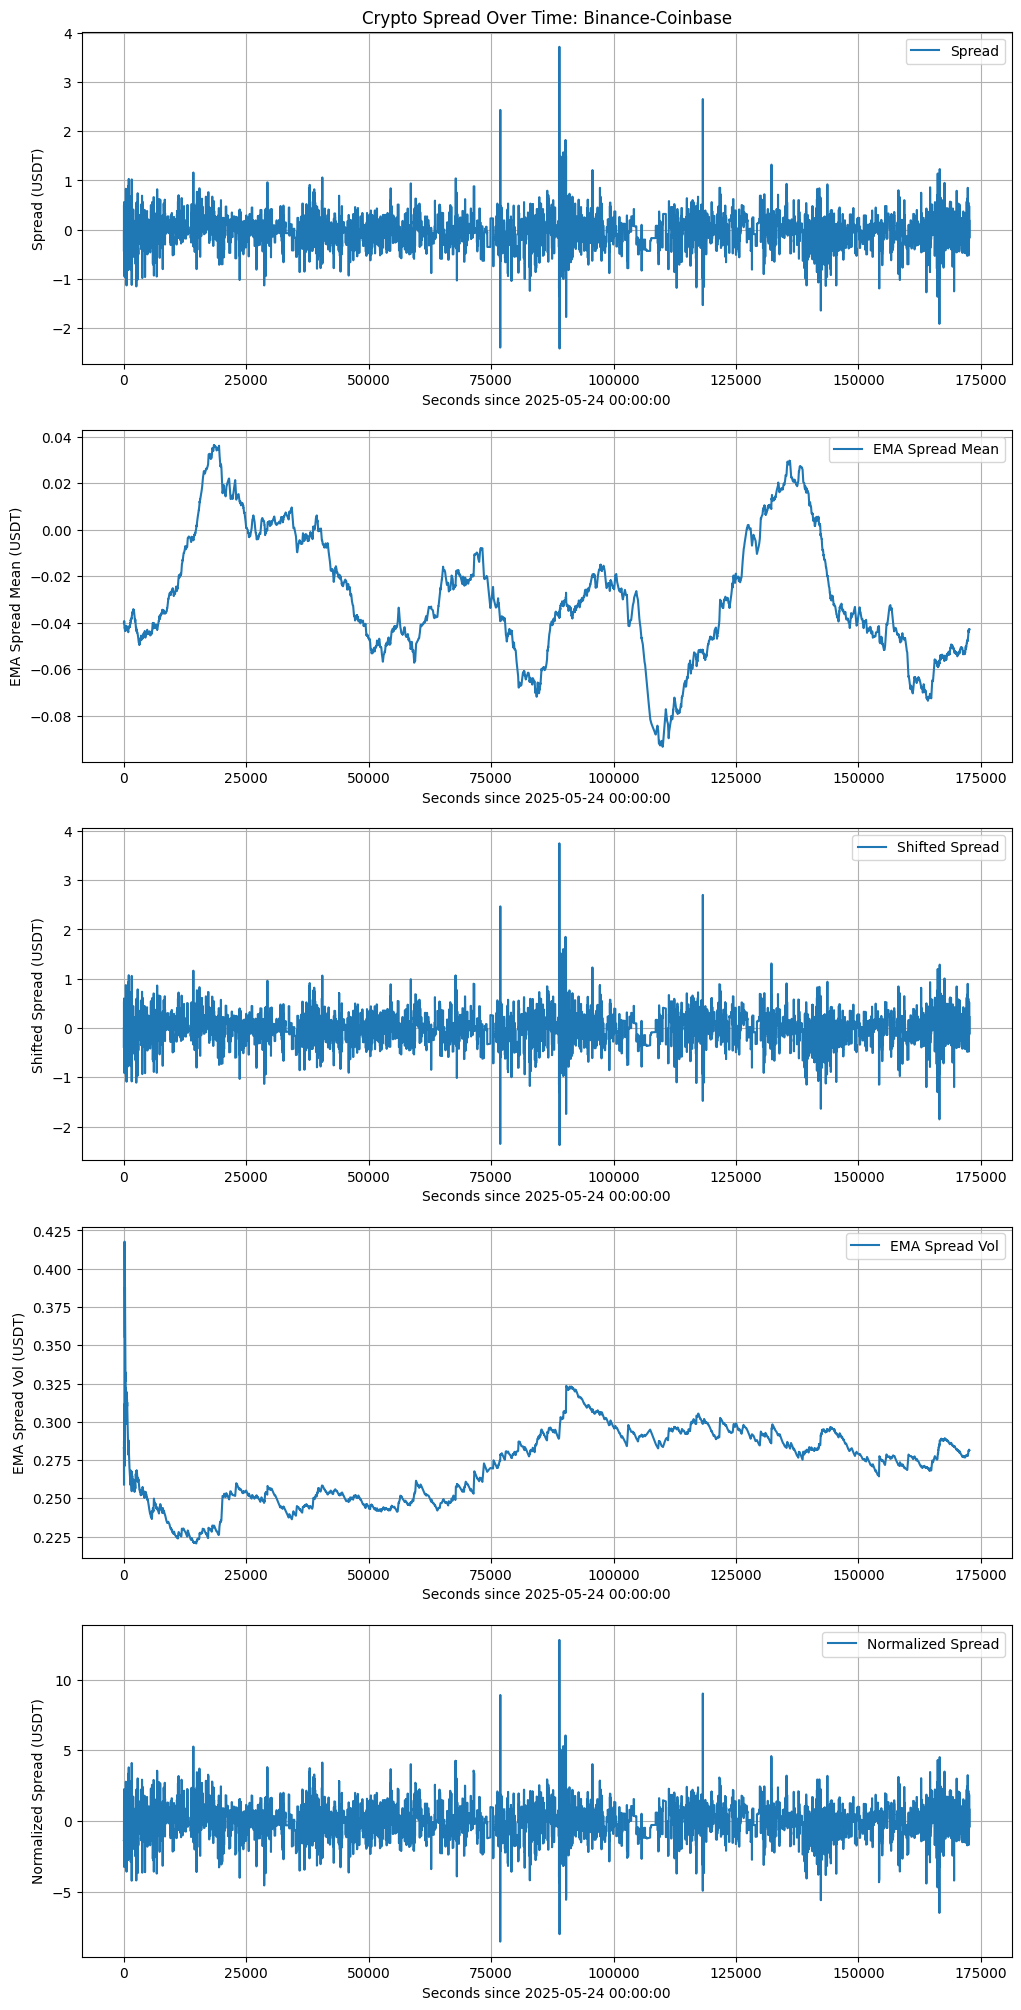

ADF Statistic for Binance-Coinbase: -27.177823445535278
p-value for Binance-Coinbase: 0.0


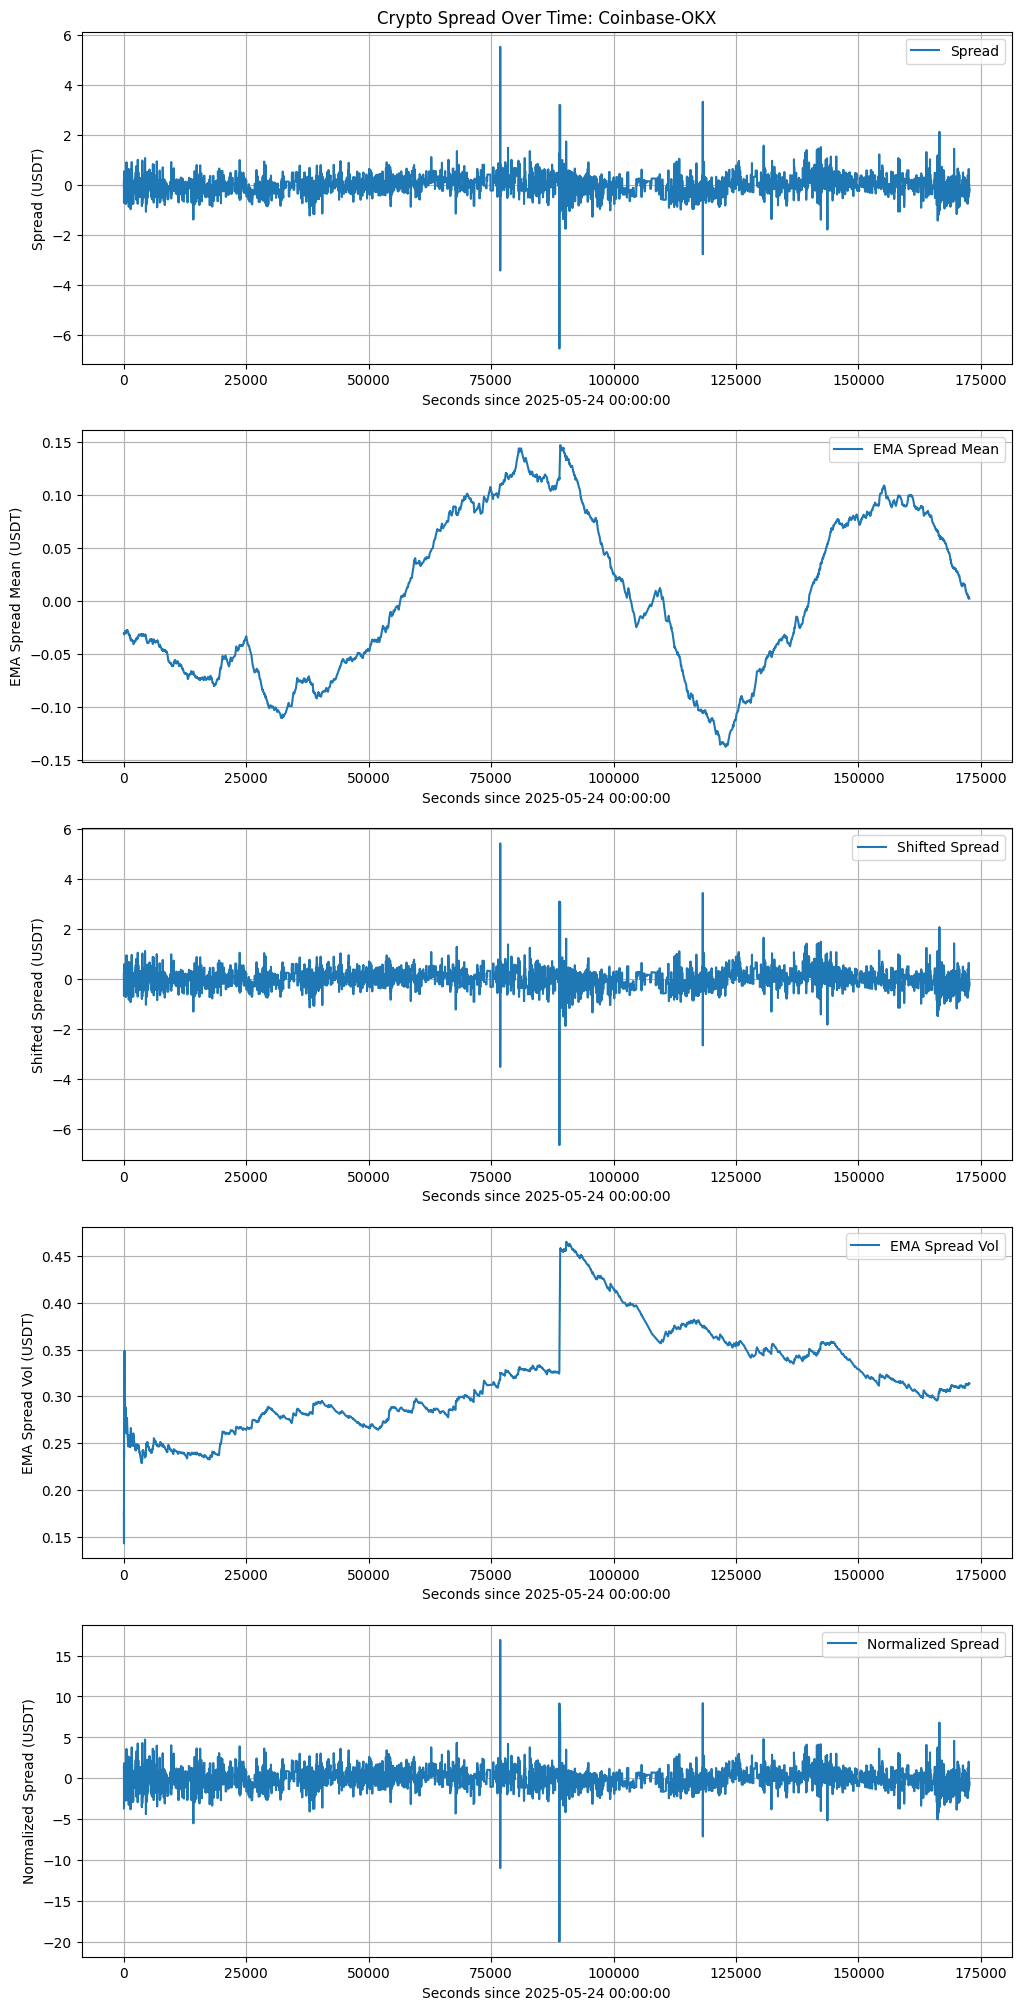

ADF Statistic for Coinbase-OKX: -25.845050845626663
p-value for Coinbase-OKX: 0.0


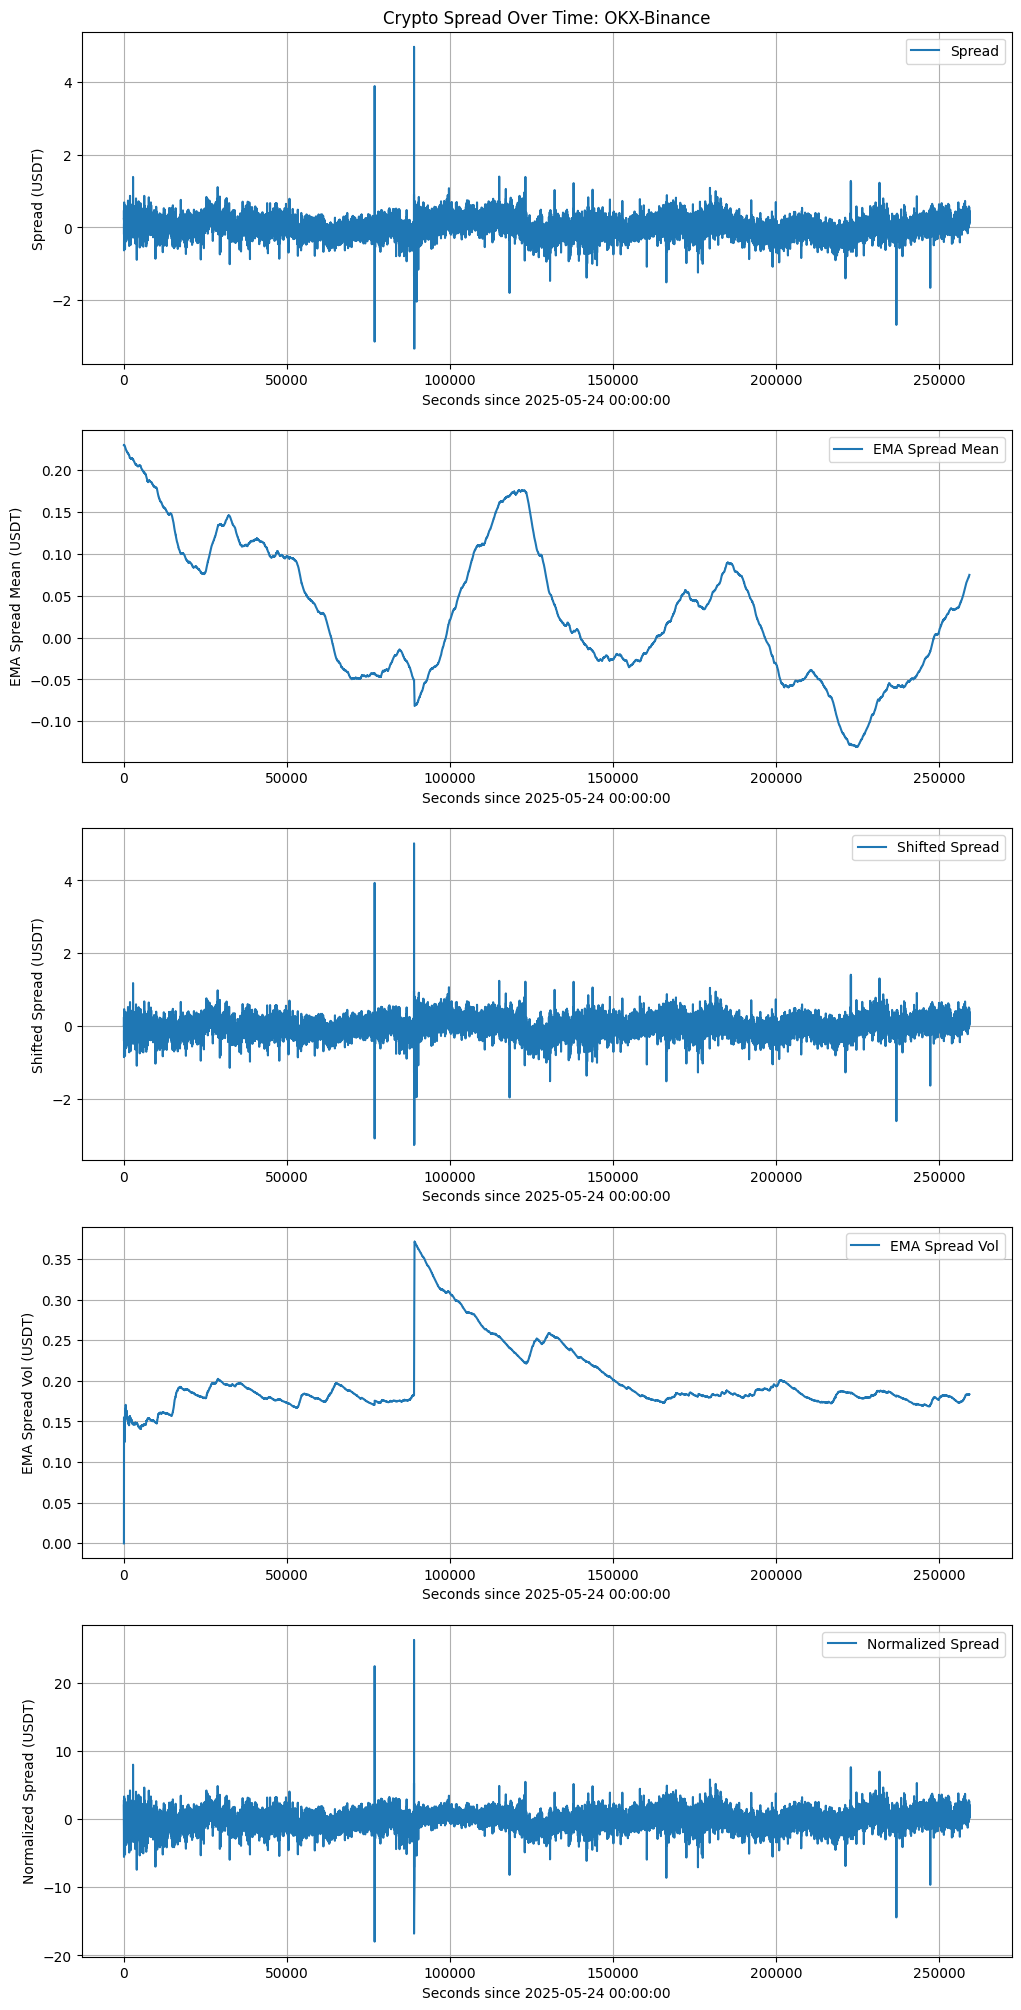

ADF Statistic for OKX-Binance: -19.107042669981176
p-value for OKX-Binance: 0.0


In [7]:
spreads = ['Binance-Coinbase', 'Coinbase-OKX', 'OKX-Binance']
exchs = ['Binance', 'Coinbase', 'OKX']

spreads_df = None
for spread in spreads:
    exch1, exch2 = spread.split('-')
    df1 = data_dict[exch1].copy()
    df2 = data_dict[exch2].copy()

    merged_df = pd.merge(df1, df2, on=['date','seconds'], how='inner')

    # Reindex common time range by filling missing seconds using forward fill
    seconds_max = merged_df['seconds'].max()
    seconds_range = np.arange(0, seconds_max + 1)
    merged_df = merged_df.set_index('seconds').reindex(seconds_range).reset_index()
    merged_df['date'] = (start_time + pd.to_timedelta(merged_df['seconds'], unit='s')).dt.date
    merged_df[[exch1, exch2]] = merged_df[[exch1, exch2]].ffill()

    # Spread calculation
    merged_df['spread'] = (merged_df[exch1] - merged_df[exch2]).astype(float)

    # EMA with half-life of 3 hours
    merged_df['ema_spread_mean'] = merged_df['spread'].ewm(halflife=3*3600, adjust=False).mean()
    merged_df['ema_spread_std'] = merged_df['spread'].ewm(halflife=3*3600, adjust=False).std()

    # Shifted spreads
    merged_df[f'shifted_spread_{spread}'] = merged_df['spread'] - merged_df['ema_spread_mean']

    # Z-score normalized shifted spreads
    merged_df[f'norm_spread_{spread}'] = merged_df[f'shifted_spread_{spread}'] / merged_df['ema_spread_std']


    # Step-by-step plotting
    fig, ax = plt.subplots(5, 1, figsize=(12, 25))

    ax[0].plot(merged_df['seconds'], merged_df['spread'], label=f'Spread')
    ax[0].set_xlabel('Seconds since ' + str(start_time))
    ax[0].set_ylabel('Spread (USDT)')
    ax[0].set_title(f'Crypto Spread Over Time: {spread}')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(merged_df['seconds'], merged_df[f'ema_spread_mean'], label=f'EMA Spread Mean')
    ax[1].set_xlabel('Seconds since ' + str(start_time))
    ax[1].set_ylabel('EMA Spread Mean (USDT)')
    ax[1].legend()
    ax[1].grid()

    ax[2].plot(merged_df['seconds'], merged_df[f'shifted_spread_{spread}'], label=f'Shifted Spread')
    ax[2].set_xlabel('Seconds since ' + str(start_time))
    ax[2].set_ylabel('Shifted Spread (USDT)')
    ax[2].legend()
    ax[2].grid()

    ax[3].plot(merged_df['seconds'], merged_df[f'ema_spread_std'], label=f'EMA Spread Vol')
    ax[3].set_xlabel('Seconds since ' + str(start_time))
    ax[3].set_ylabel('EMA Spread Vol (USDT)')
    ax[3].legend()
    ax[3].grid()

    ax[4].plot(merged_df['seconds'], merged_df[f'norm_spread_{spread}'], label=f'Normalized Spread')
    ax[4].set_xlabel('Seconds since ' + str(start_time))
    ax[4].set_ylabel('Normalized Spread (USDT)')
    ax[4].legend()
    ax[4].grid()

    plt.show()

    # Augmented Dickey-Fuller test for stationarity
    result = adfuller(merged_df[f'norm_spread_{spread}'].dropna())
    print(f'ADF Statistic for {spread}: {result[0]}')
    print(f'p-value for {spread}: {result[1]}')

    merged_df.drop([exch1, exch2, 'spread', 'ema_spread_mean', 'ema_spread_std', f'shifted_spread_{spread}'], axis=1, inplace=True)

    if spreads_df is None:
        spreads_df = merged_df
    else:
        spreads_df = pd.merge(spreads_df, merged_df, on=['date','seconds'], how='outer')


for exch in exchs:
    df = data_dict[exch].copy()

    spreads_df = pd.merge(spreads_df, df[['date','seconds',exch]], on=['date','seconds'], how='outer')

for exch in exchs:
    spreads_df[exch] = spreads_df[exch].ffill()

In [8]:
display(spreads_df)

,seconds,date,norm_spread_Binance-Coinbase,norm_spread_Coinbase-OKX,norm_spread_OKX-Binance,Binance,Coinbase,OKX
0,0,2025-05-24,NaN,NaN,NaN,2526.17,NaN,2526.40
1,1,2025-05-24,NaN,NaN,NaN,2526.17,NaN,2526.40
2,2,2025-05-24,NaN,NaN,1.999807,2525.99,NaN,2526.30
3,3,2025-05-24,NaN,NaN,1.612756,2526.00,NaN,2526.30
4,4,2025-05-24,NaN,NaN,1.555246,2525.89,NaN,2526.30
...,...,...,...,...,...,...,...,...
259194,259194,2025-05-26,NaN,NaN,1.607075,2563.88,2551.62,2564.26
259195,259195,2025-05-26,NaN,NaN,1.606891,2563.89,2551.62,2564.26
259196,259196,2025-05-26,NaN,NaN,1.606706,2563.89,2551.62,2564.26
259197,259197,2025-05-26,NaN,NaN,0.136346,2563.70,2551.62,2563.80


**Parameters**

In [10]:
M_grid = [x for x in range(1,62,10)]                        # look-back period (in seconds)
N_grid = [x for x in range(1,32,10)]                        # Nth max-min in look-back period
g_grid = [1.5, 2.0, 2.5]                                    # entry level in standard deviations
j_grid = [0.0, 0.5, 1.0]                                    # take-profit level
l_grid = [2.5, 5, 7.5]                                      # stop-loss level
C_grid = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01]            # transaction cost per trade

initial_capital = 80_000.00
cutoff_capital = 40_000.00

In [11]:
@functools.lru_cache(maxsize=None)
def m_sliding_window_sort(spread, M):
    windows = sliding_window_view(spreads_df[f'norm_spread_{spread}'].values, window_shape=M)
    sorted_windows = np.sort(windows, axis=1)
    def any_null(row):
        return np.isnan(row).any()
    mask = np.apply_along_axis(any_null, 1, windows)
    # replace any null with all NaNs
    sorted_windows[mask] = np.nan

    return sorted_windows

@functools.lru_cache(maxsize=None)
def m_window_nth_max_min(spread, M, N):

    # pL: Nth largest which implies there are (N-1) values larger than it. This shows this is a persistent positive spread
    # pL = sorted_series.iloc[-N]
    # pS: Nth smallest which implies there are (N-1) values smaller than it. This shows this is a persistent negative spread
    # pS = sorted_series.iloc[N-1]
    p = m_sliding_window_sort(spread, M)[:, [-N,N-1]]
    p = pd.DataFrame(p, columns=['pL', 'pS'])
    p['seconds'] = spreads_df['seconds']
    exch1, exch2 = spread.split('-')
    p[exch1] = spreads_df[exch1].astype(float)
    p[exch2] = spreads_df[exch2].astype(float)
    p.dropna(inplace=True)
    return p

In [12]:
# @functools.lru_cache(maxsize=None)
def simulate_trading(M, N, g, j, l):
    transaction_series = []
    for spread in spreads:
        exch1, exch2 = spread.split('-')
        p = m_window_nth_max_min(spread, M, N)

        long_open = False
        long_entry_price_exch1 = None
        long_entry_price_exch2 = None

        short_open = False
        short_entry_price_exch1 = None
        short_entry_price_exch2 = None

        day_trading_stop = None

        for ind, row in p.iterrows():
            seconds = row['seconds']
            date = (start_time + pd.to_timedelta(seconds, unit='s')).date()
            price_exch1 = row[exch1]
            price_exch2 = row[exch2]
            pL = row['pL']
            pS = row['pS']

            if day_trading_stop:
                if date==day_trading_stop:
                    continue
                else:
                    day_trading_stop = None

            if short_open:
                if pL <= j:
                    short_open = False
                elif pL>= l:
                    short_open = False
                    day_trading_stop = date

                if not short_open:
                    transaction_series.append([seconds, (short_entry_price_exch1 - short_entry_price_exch2) * (g - j), 2 * (short_entry_price_exch1 + short_entry_price_exch2), (short_entry_price_exch1 - price_exch1) - (short_entry_price_exch2 - price_exch2), (short_entry_price_exch1  + short_entry_price_exch2 + price_exch1 + price_exch2), 'short', spread])
            elif not long_open and (pL >= g) and (pL < l):
                short_open = True
                short_entry_price_exch1 = price_exch1
                short_entry_price_exch2 = price_exch2

            if long_open:
                if pS >= -j:
                    long_open = False
                elif pS <= -l:
                    long_open = False
                    day_trading_stop = date

                if not long_open:
                    transaction_series.append([seconds, (long_entry_price_exch2 - long_entry_price_exch1) * (g - j), 2 * (long_entry_price_exch1 + long_entry_price_exch2), (price_exch1 - long_entry_price_exch1) - (price_exch2 - long_entry_price_exch2), (long_entry_price_exch1 + long_entry_price_exch2 + price_exch1 + price_exch2), 'long', spread])
            elif not short_open and (pS <= -g) and (pS > -l):
                long_open = True
                long_entry_price_exch1 = price_exch1
                long_entry_price_exch2 = price_exch2

        if long_open or short_open:
            row = p.iloc[-1]
            seconds = row['seconds']
            price_exch1 = row[exch1]
            price_exch2 = row[exch2]
            if long_open:
                transaction_series.append([seconds, (long_entry_price_exch2 - long_entry_price_exch1) * (g - j), 2 * (long_entry_price_exch1 + long_entry_price_exch2), (price_exch1 - long_entry_price_exch1) - (price_exch2 - long_entry_price_exch2), (long_entry_price_exch1 + long_entry_price_exch2 + price_exch1 + price_exch2), 'long', spread])
            else:
                transaction_series.append([seconds, (short_entry_price_exch1 - short_entry_price_exch2) * (g - j), 2 * (short_entry_price_exch1 + short_entry_price_exch2), (short_entry_price_exch1 - price_exch1) - (short_entry_price_exch2 - price_exch2), (short_entry_price_exch1  + short_entry_price_exch2 + price_exch1 + price_exch2), 'short', spread])


    transaction_series = pd.DataFrame(transaction_series, columns=['seconds', 'potential_pnl', 'potential_trading_cost_mult', 'pnl', 'trading_cost_mult','trade_type', 'spread'])
    transaction_series.sort_values(by=['seconds'], inplace=True)

    return transaction_series

In [13]:
grid_search = []
for M in M_grid:
    for N in N_grid:
        if N > M:
            continue
        for g in g_grid:
            for j in j_grid:
                for l in l_grid:
                    if l <= g:
                        continue
                    print(f'Testing parameters: M={M}, N={N}, g={g}, j={j}, l={l}')
                    transactions = simulate_trading(M, N, g, j, l)
                    if len(transactions) < 15:
                        continue
                    for C in C_grid:
                        transactions['trade'] = 1
                        transactions['potential_trading_cost'] = C * transactions['potential_trading_cost_mult']
                        transactions.loc[(transactions['potential_pnl'] < transactions['potential_trading_cost']), 'trade'] = 0
                        transactions['trading_cost'] = C * transactions['trading_cost_mult']
                        transactions['actual_pnl'] = (transactions['pnl'] - transactions['trading_cost']) * transactions['trade']
                        transactions['cumulative_pnl'] = transactions['actual_pnl'].cumsum()
                        final_capital = initial_capital + transactions['cumulative_pnl'].iloc[-1]
                        num_transactions = transactions['trade'].sum()
                        grid_search.append([M, N, g, j, l, C, final_capital, num_transactions])

grid_search = pd.DataFrame(grid_search, columns=['M', 'N', 'g', 'j', 'l', 'C', 'final_capital', 'num_transactions'])
grid_search = grid_search.sort_values(by='final_capital', ascending=False)
display(grid_search)

Testing parameters: M=1, N=1, g=1.5, j=0.0, l=2.5
Testing parameters: M=1, N=1, g=1.5, j=0.0, l=5
Testing parameters: M=1, N=1, g=1.5, j=0.0, l=7.5
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=2.5
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=5
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=7.5
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=2.5
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=5
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=2.5
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=5
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=2.5
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=5
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=2.5
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=5
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=7.5
Testing parameters: M=1, N=1, g=2.5, j=0.0, l=5
Testing parameters: M=1, N=1, g=2.5, j=0.0, l=7.5
Testing parame

,M,N,g,j,l,C,final_capital,num_transactions
30,1,1,1.5,0.5,7.5,0.0000,83264.900000,7319
48,1,1,1.5,1.0,7.5,0.0000,83239.920000,8938
12,1,1,1.5,0.0,7.5,0.0000,82822.520000,5159
84,1,1,2.0,0.5,7.5,0.0000,81867.950000,3274
102,1,1,2.0,1.0,7.5,0.0000,81848.040000,3814
...,...,...,...,...,...,...,...,...
373,11,11,2.0,0.5,7.5,0.0001,79861.555999,193
787,21,21,2.0,0.0,7.5,0.0001,79836.150075,209
781,21,21,2.0,0.0,5.0,0.0001,79834.405639,208
355,11,11,2.0,0.0,7.5,0.0001,79752.598984,329


In [30]:
top_search_results_by_cost = grid_search.sort_values(by='final_capital', ascending=False).groupby('C').head(10).sort_values(by=['C','final_capital'], ascending=[True, False])

display(top_search_results_by_cost)

,M,N,g,j,l,C,final_capital,num_transactions
30,1,1,1.5,0.5,7.5,0.0000,83264.900000,7319
48,1,1,1.5,1.0,7.5,0.0000,83239.920000,8938
12,1,1,1.5,0.0,7.5,0.0000,82822.520000,5159
84,1,1,2.0,0.5,7.5,0.0000,81867.950000,3274
102,1,1,2.0,1.0,7.5,0.0000,81848.040000,3814
66,1,1,2.0,0.0,7.5,0.0000,81770.390000,2624
24,1,1,1.5,0.5,5.0,0.0000,81283.560000,2467
42,1,1,1.5,1.0,5.0,0.0000,81258.360000,2930
6,1,1,1.5,0.0,5.0,0.0000,81162.670000,1844
126,1,1,2.5,0.5,7.5,0.0000,81021.690000,1401


In [29]:
worst_search_results_by_cost = grid_search.sort_values(by='final_capital', ascending=False).groupby('C').tail(5).sort_values(by=['C','final_capital'], ascending=[True, True])

display(worst_search_results_by_cost)

,M,N,g,j,l,C,final_capital,num_transactions
324,11,11,1.5,1.0,2.5,0.0000,79979.780000,211
720,21,21,1.5,0.0,2.5,0.0000,79984.700000,132
738,21,21,1.5,0.5,2.5,0.0000,79985.280000,161
756,21,21,1.5,1.0,2.5,0.0000,79988.190000,167
1140,31,11,2.5,1.0,5.0,0.0000,79988.270000,97
349,11,11,2.0,0.0,5.0,0.0001,79750.629649,327
355,11,11,2.0,0.0,7.5,0.0001,79752.598984,329
781,21,21,2.0,0.0,5.0,0.0001,79834.405639,208
787,21,21,2.0,0.0,7.5,0.0001,79836.150075,209
373,11,11,2.0,0.5,7.5,0.0001,79861.555999,193


**Observations**
- Maximum profit achieved with low transaction costs.
- Higher stop-loss levels tend to yield better results by avoiding frequent stop-outs.
- Small look-back periods (M) with low N values are more effective.
- Entry levels (g) around 1.5-2.0 standard deviations are optimal.
- Take-profit levels (j) have less impact compared to stop-loss (l).
- Non-zero transaction costs significantly reduce profitability.
- No trades executed at high transaction costs due to unprofitable conditions.
- Optimal parameters vary with transaction costs.
- Maximum losses with zero transaction cost happen for low stop-loss levels, leading to frequent stop-outs.

Testing parameters: M=1.0, N=1.0, g=1.5, j=0.5, l=7.5, C=0.0
Num of transactions:  7319
Final Capital: 83264.90
Total return: 4.0811%
Sharpe Ratio Seconds: 0.1227
Sharpe Ratio Minutes: 0.5976
Sharpe Ratio Hours: 1.3817
Max Drawdown: 0.0000%
Win Rate: 100.0000%
Total Trading Costs: 0.00


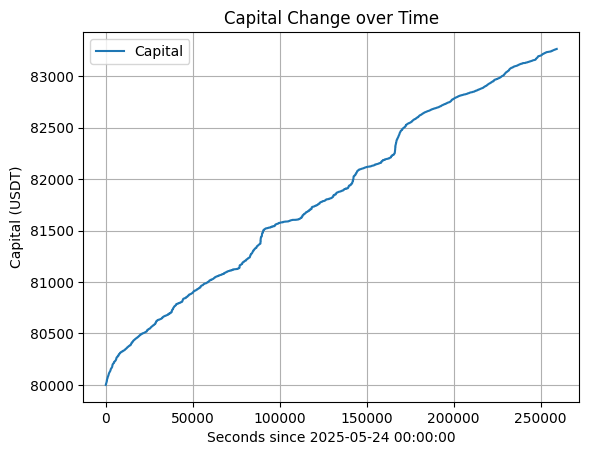

Testing parameters: M=11.0, N=1.0, g=1.5, j=0.0, l=7.5, C=0.0001
Num of transactions:  156
Final Capital: 80098.24
Total return: 0.1228%
Sharpe Ratio Seconds: 0.0137
Sharpe Ratio Minutes: 0.0993
Sharpe Ratio Hours: 0.4572
Max Drawdown: -0.0004%
Win Rate: 77.5641%
Total Trading Costs: 158.18


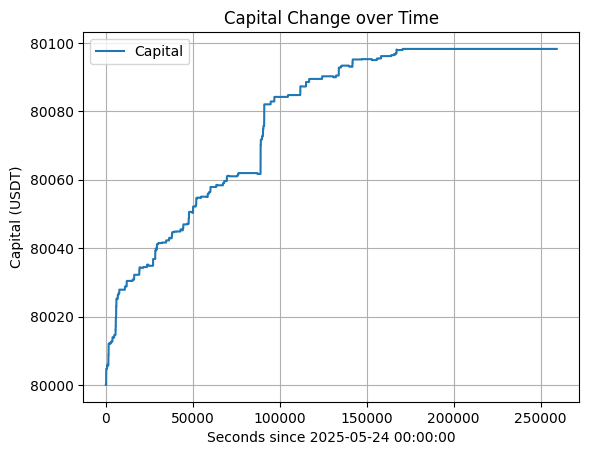

Testing parameters: M=61.0, N=21.0, g=1.5, j=0.5, l=5.0, C=0.0005
Num of transactions:  1
Final Capital: 80002.41
Total return: 0.0030%
Sharpe Ratio Seconds: 0.0020
Sharpe Ratio Minutes: 0.0153
Sharpe Ratio Hours: 0.1187
Max Drawdown: 0.0000%
Win Rate: 100.0000%
Total Trading Costs: 5.05


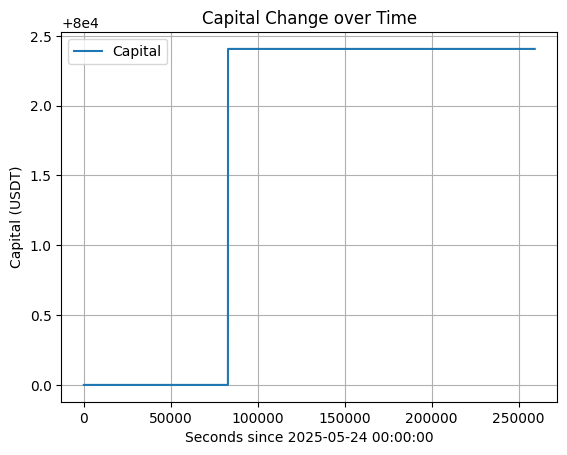

Testing parameters: M=11.0, N=11.0, g=1.5, j=1.0, l=2.5, C=0.0
Num of transactions:  211
Final Capital: 79979.78
Total return: -0.0253%
Sharpe Ratio Seconds: -0.0030
Sharpe Ratio Minutes: -0.0231
Sharpe Ratio Hours: -0.1383
Max Drawdown: -0.0379%
Win Rate: 46.9194%
Total Trading Costs: 0.00


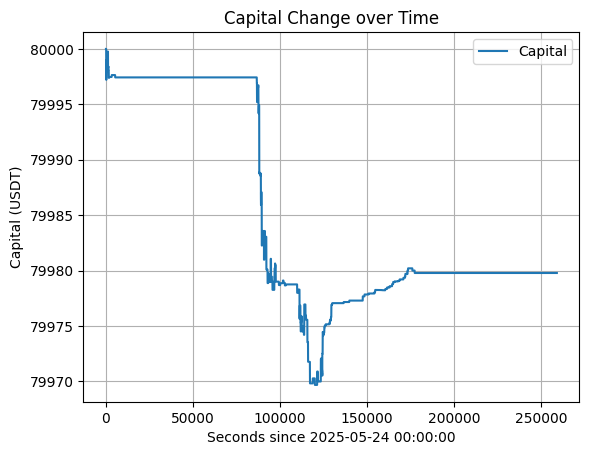

Testing parameters: M=11.0, N=11.0, g=2.0, j=0.0, l=5.0, C=0.0001
Num of transactions:  327
Final Capital: 79750.63
Total return: -0.3117%
Sharpe Ratio Seconds: -0.0158
Sharpe Ratio Minutes: -0.1192
Sharpe Ratio Hours: -0.6235
Max Drawdown: -0.3117%
Win Rate: 19.2661%
Total Trading Costs: 331.06


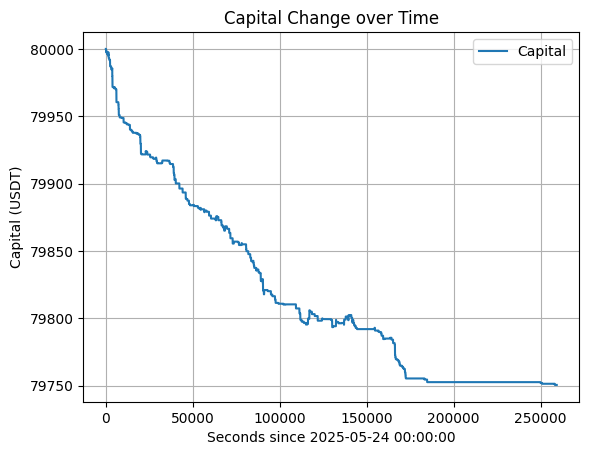

Testing parameters: M=21.0, N=11.0, g=2.0, j=0.0, l=5.0, C=0.0005
Num of transactions:  11
Final Capital: 79974.73
Total return: -0.0316%
Sharpe Ratio Seconds: -0.0046
Sharpe Ratio Minutes: -0.0358
Sharpe Ratio Hours: -0.2799
Max Drawdown: -0.0316%
Win Rate: 18.1818%
Total Trading Costs: 55.50


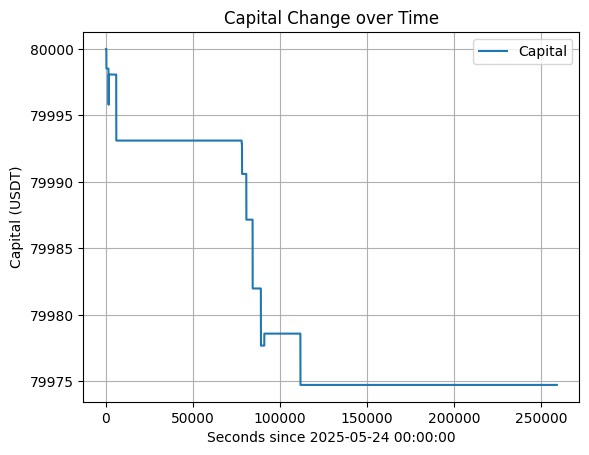

Testing parameters: M=11.0, N=1.0, g=2.5, j=0.0, l=5.0, C=0.001
Num of transactions:  3
Final Capital: 79985.02
Total return: -0.0187%
Sharpe Ratio Seconds: -0.0034
Sharpe Ratio Minutes: -0.0220
Sharpe Ratio Hours: -0.1214
Max Drawdown: -0.0187%
Win Rate: 0.0000%
Total Trading Costs: 30.21


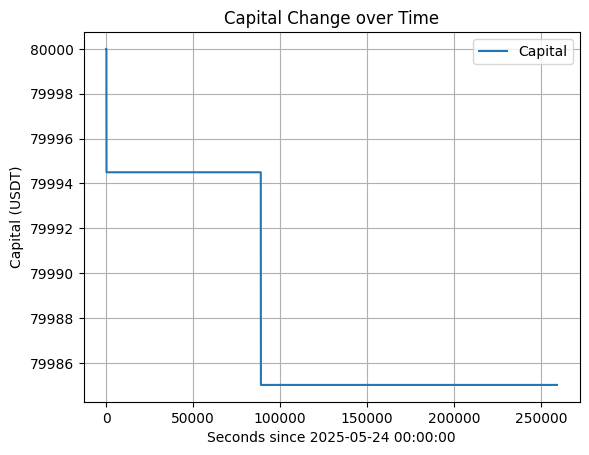

In [57]:
top = grid_search.sort_values(by='final_capital', ascending=False).groupby('C').head(1).sort_values(by=['C','final_capital'], ascending=[True, False])
worst = grid_search.sort_values(by='final_capital', ascending=False).groupby('C').tail(1).sort_values(by=['C','final_capital'], ascending=[True, True])

to_check = pd.concat([top, worst])
to_check = to_check.loc[to_check['num_transactions']!=0]

for index, row in to_check.iterrows():
    M, N, g, j, l, C, _, _ = row.tolist()

    transactions = simulate_trading(M, N, g, j, l)

    transactions['trade'] = 1
    transactions['potential_trading_cost'] = C * transactions['potential_trading_cost_mult']
    transactions.loc[(transactions['potential_pnl'] < transactions['potential_trading_cost']), 'trade'] = 0
    transactions['trading_cost'] = C * transactions['trading_cost_mult']
    transactions['actual_pnl'] = (transactions['pnl'] - transactions['trading_cost']) * transactions['trade']

    num_transactions = transactions['trade'].sum()
    total_trading_costs = (transactions['trading_cost'] * transactions['trade']).sum()

    win_rate = (transactions['actual_pnl'] > 0).sum() / num_transactions

    transactions = transactions.groupby('seconds')['actual_pnl'].sum().reset_index()

    transactions = transactions.set_index('seconds').reindex(spreads_df['seconds'].tolist()).reset_index()
    transactions['actual_pnl'] = transactions['actual_pnl'].fillna(0)
    transactions['cumulative_pnl'] = transactions['actual_pnl'].cumsum()
    transactions['final_capital'] = initial_capital + transactions['cumulative_pnl']

    # Calculate total return
    transactions['ret_sec'] = (transactions['final_capital'].pct_change()).fillna(0)
    transactions['ret_min'] = ((transactions['final_capital'] - transactions['final_capital'].shift(61)) / transactions['final_capital'].shift(61)).fillna(0)
    transactions['ret_hour'] = ((transactions['final_capital'] - transactions['final_capital'].shift(3601)) / transactions['final_capital'].shift(3601)).fillna(0)

    max_drawdown = ((transactions['final_capital'] - transactions['final_capital'].cummax()) / transactions['final_capital'].cummax()).min()

    sharpe_sec = transactions['ret_sec'].mean() / transactions['ret_sec'].std()
    sharpe_min = transactions['ret_min'].mean() / transactions['ret_min'].std()
    sharpe_hour = transactions['ret_hour'].mean() / transactions['ret_hour'].std()

    total_return = transactions['cumulative_pnl'].iloc[-1] / initial_capital

    print(f'Testing parameters: M={M}, N={N}, g={g}, j={j}, l={l}, C={C}')
    print(f'Num of transactions: ', num_transactions)
    print(f'Final Capital: {transactions['final_capital'].iloc[-1]:.2f}')
    print(f'Total return: {total_return*100:.4f}%')
    print(f'Sharpe Ratio Seconds: {sharpe_sec:.4f}')
    print(f'Sharpe Ratio Minutes: {sharpe_min:.4f}')
    print(f'Sharpe Ratio Hours: {sharpe_hour:.4f}')
    print(f'Max Drawdown: {max_drawdown*100:.4f}%')
    print(f'Win Rate: {win_rate*100:.4f}%')
    print(f'Total Trading Costs: {total_trading_costs:.2f}')

    plt.plot(transactions['seconds'], transactions['final_capital'], label='Capital')
    plt.xlabel('Seconds since ' + str(start_time))
    plt.ylabel('Capital (USDT)')
    plt.title('Capital Change over Time')
    plt.legend()
    plt.grid()
    plt.show()


**Aggressive Trade Stacking Simulation**
- Stacking more position when one is already open

In [38]:
M_grid = [1, 11, 21]                                    # look-back period (in seconds)
N_grid = [1, 11, 21]                                    # Nth max-min in look-back period
g_grid = [1.5, 2.0]                                     # entry level in standard deviations
j_grid = [0.0, 0.5, 1.0]                                # take-profit level
l_grid = [5.0, 7.5, 10]                                 # stop-loss level
C_grid = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01]        # transaction cost per trade

initial_capital = 80_000.00
cutoff_capital = 40_000.00

In [33]:
# @functools.lru_cache(maxsize=None)
def simulate_aggressive_trading(M, N, g, j, l):
    transaction_series = []
    for spread in spreads:
        exch1, exch2 = spread.split('-')
        p = m_window_nth_max_min(spread, M, N)

        long_open = False
        long_entry_prices = []

        short_open = False
        short_entry_prices = []

        day_trading_stop = None

        for ind, row in p.iterrows():
            seconds = row['seconds']
            date = (start_time + pd.to_timedelta(seconds, unit='s')).date()
            price_exch1 = row[exch1]
            price_exch2 = row[exch2]
            pL = row['pL']
            pS = row['pS']

            if day_trading_stop:
                if date==day_trading_stop:
                    continue
                else:
                    day_trading_stop = None

            if short_open:
                if pL <= j:
                    short_open = False
                elif pL>= l:
                    short_open = False
                    day_trading_stop = date

                if not short_open:
                    for short_entry_price_exch1, short_entry_price_exch2 in short_entry_prices:
                        transaction_series.append([seconds, (short_entry_price_exch1 - short_entry_price_exch2) * (g - j), 2 * (short_entry_price_exch1 + short_entry_price_exch2), (short_entry_price_exch1 - price_exch1) - (short_entry_price_exch2 - price_exch2), (short_entry_price_exch1  + short_entry_price_exch2 + price_exch1 + price_exch2), 'short', spread])
                    short_entry_prices = []

            # Stacking more position even if one is already open
            if (pL >= g) and (pL < l):
                short_open = True
                short_entry_prices.append([price_exch1, price_exch2])

            if long_open:
                if pS >= -j:
                    long_open = False
                elif pS <= -l:
                    long_open = False
                    day_trading_stop = date

                if not long_open:
                    for long_entry_price_exch1, long_entry_price_exch2 in long_entry_prices:
                        transaction_series.append([seconds, (long_entry_price_exch2 - long_entry_price_exch1) * (g - j), 2 * (long_entry_price_exch1 + long_entry_price_exch2), (price_exch1 - long_entry_price_exch1) - (price_exch2 - long_entry_price_exch2), (long_entry_price_exch1 + long_entry_price_exch2 + price_exch1 + price_exch2), 'long', spread])
                    long_entry_prices = []

            # Stacking more position even if one is already open
            if (pS <= -g) and (pS > -l):
                long_open = True
                long_entry_prices.append([price_exch1, price_exch2])

        if long_open or short_open:
            row = p.iloc[-1]
            seconds = row['seconds']
            price_exch1 = row[exch1]
            price_exch2 = row[exch2]
            if long_open:
                for long_entry_price_exch1, long_entry_price_exch2 in long_entry_prices:
                    transaction_series.append([seconds, (long_entry_price_exch2 - long_entry_price_exch1) * (g - j), 2 * (long_entry_price_exch1 + long_entry_price_exch2), (price_exch1 - long_entry_price_exch1) - (price_exch2 - long_entry_price_exch2), (long_entry_price_exch1 + long_entry_price_exch2 + price_exch1 + price_exch2), 'long', spread])
            else:
                for short_entry_price_exch1, short_entry_price_exch2 in short_entry_prices:
                    transaction_series.append([seconds, (short_entry_price_exch1 - short_entry_price_exch2) * (g - j), 2 * (short_entry_price_exch1 + short_entry_price_exch2), (short_entry_price_exch1 - price_exch1) - (short_entry_price_exch2 - price_exch2), (short_entry_price_exch1  + short_entry_price_exch2 + price_exch1 + price_exch2), 'short', spread])


    transaction_series = pd.DataFrame(transaction_series, columns=['seconds', 'potential_pnl', 'potential_trading_cost_mult', 'pnl', 'trading_cost_mult','trade_type', 'spread'])
    transaction_series.sort_values(by=['seconds'], inplace=True)

    return transaction_series

In [39]:
grid_search_aggressive = []
for M in M_grid:
    for N in N_grid:
        if N > M:
            continue
        for g in g_grid:
            for j in j_grid:
                for l in l_grid:
                    if l <= g:
                        continue
                    print(f'Testing parameters: M={M}, N={N}, g={g}, j={j}, l={l}')
                    transactions = simulate_aggressive_trading(M, N, g, j, l)
                    if len(transactions) < 15:
                        continue
                    for C in C_grid:
                        transactions['trade'] = 1
                        transactions['potential_trading_cost'] = C * transactions['potential_trading_cost_mult']
                        transactions.loc[(transactions['potential_pnl'] < transactions['potential_trading_cost']), 'trade'] = 0
                        transactions['trading_cost'] = C * transactions['trading_cost_mult']
                        transactions['actual_pnl'] = (transactions['pnl'] - transactions['trading_cost']) * transactions['trade']
                        transactions['cumulative_pnl'] = transactions['actual_pnl'].cumsum()
                        final_capital = initial_capital + transactions['cumulative_pnl'].iloc[-1]
                        num_transactions = transactions['trade'].sum()
                        grid_search_aggressive.append([M, N, g, j, l, C, final_capital, num_transactions])

grid_search_aggressive = pd.DataFrame(grid_search_aggressive, columns=['M', 'N', 'g', 'j', 'l', 'C', 'final_capital', 'num_transactions'])
grid_search_aggressive = grid_search_aggressive.sort_values(by='final_capital', ascending=False)
display(grid_search_aggressive)

Testing parameters: M=1, N=1, g=1.5, j=0.0, l=5.0
Testing parameters: M=1, N=1, g=1.5, j=0.0, l=7.5
Testing parameters: M=1, N=1, g=1.5, j=0.0, l=10
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=5.0
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=7.5
Testing parameters: M=1, N=1, g=1.5, j=0.5, l=10
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=5.0
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=7.5
Testing parameters: M=1, N=1, g=1.5, j=1.0, l=10
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=5.0
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=0.0, l=10
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=5.0
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=0.5, l=10
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=5.0
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=7.5
Testing parameters: M=1, N=1, g=2.0, j=1.0, l=10
Testing parameters: M=11, N=1, g=1.5, j=0.0, l=5.0
Testing parameters: M=11, N=1, g=1.5, j=0.0, l=7.5
Test

,M,N,g,j,l,C,final_capital,num_transactions
336,21,1,1.5,0.0,10.0,0.0000,129175.040000,92685
6,1,1,1.5,0.0,7.5,0.0000,125930.510000,57788
24,1,1,1.5,0.5,7.5,0.0000,123368.240000,61424
120,11,1,1.5,0.0,10.0,0.0000,122181.000000,73814
354,21,1,1.5,0.5,10.0,0.0000,121523.470000,92685
...,...,...,...,...,...,...,...,...
247,11,11,1.5,0.5,10.0,0.0001,74462.747520,8223
235,11,11,1.5,0.5,5.0,0.0001,74412.329374,8128
223,11,11,1.5,0.0,7.5,0.0001,73620.839380,12867
229,11,11,1.5,0.0,10.0,0.0001,73572.637550,12914


In [40]:
top_aggressive_search_results_by_cost = grid_search_aggressive.sort_values(by='final_capital', ascending=False).groupby('C').head(5).sort_values(by=['C','final_capital'], ascending=[True, False])

display(top_aggressive_search_results_by_cost)

,M,N,g,j,l,C,final_capital,num_transactions
336,21,1,1.5,0.0,10.0,0.0000,129175.040000,92685
6,1,1,1.5,0.0,7.5,0.0000,125930.510000,57788
24,1,1,1.5,0.5,7.5,0.0000,123368.240000,61424
120,11,1,1.5,0.0,10.0,0.0000,122181.000000,73814
354,21,1,1.5,0.5,10.0,0.0000,121523.470000,92685
7,1,1,1.5,0.0,7.5,0.0001,90594.649233,16516
25,1,1,1.5,0.5,7.5,0.0001,89754.663840,10655
13,1,1,1.5,0.0,10.0,0.0001,89167.325613,14026
31,1,1,1.5,0.5,10.0,0.0001,88811.809200,9229
337,21,1,1.5,0.0,10.0,0.0001,88524.877192,13158


In [41]:
worst_aggressive_search_results_by_cost = grid_search_aggressive.sort_values(by='final_capital', ascending=False).groupby('C').tail(5).sort_values(by=['C','final_capital'], ascending=[True, True])

display(worst_aggressive_search_results_by_cost)

,M,N,g,j,l,C,final_capital,num_transactions
528,21,11,2.0,1.0,7.5,0.0000,80321.300000,13430
522,21,11,2.0,1.0,5.0,0.0000,80389.080000,13387
636,21,21,2.0,1.0,7.5,0.0000,80602.370000,7693
630,21,21,2.0,1.0,5.0,0.0000,80628.580000,7658
642,21,21,2.0,1.0,10.0,0.0000,80649.600000,7734
217,11,11,1.5,0.0,5.0,0.0001,73515.785374,12814
229,11,11,1.5,0.0,10.0,0.0001,73572.637550,12914
223,11,11,1.5,0.0,7.5,0.0001,73620.839380,12867
235,11,11,1.5,0.5,5.0,0.0001,74412.329374,8128
247,11,11,1.5,0.5,10.0,0.0001,74462.747520,8223


**Observations**
- Profitability and potential losses get magnified with aggressive trading.
- Lower N values results in higher profitability and vice versa.
- Wider bands (j < g < l) results in greater profitability.
- No trading happens at higher trading costs.

Testing parameters: M=21.0, N=1.0, g=1.5, j=0.0, l=10.0, C=0.0
Num of transactions:  92685
Final Capital: 129175.04
Total return: 61.4688%
Sharpe Ratio Seconds: 0.0229
Sharpe Ratio Minutes: 0.1745
Sharpe Ratio Hours: 0.7565
Max Drawdown: -0.0124%
Win Rate: 98.3816%
Total Trading Costs: 0.00


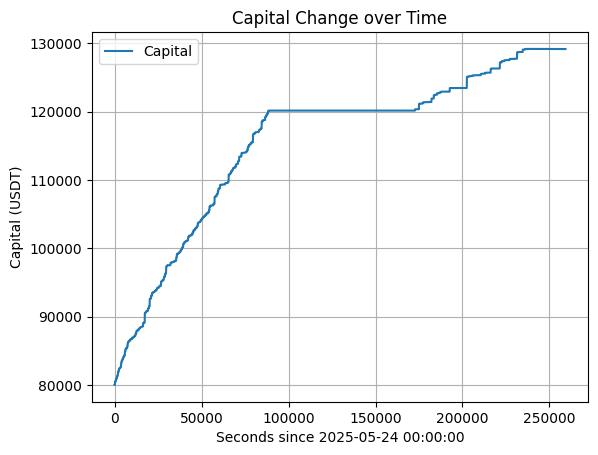

Testing parameters: M=1.0, N=1.0, g=1.5, j=0.0, l=7.5, C=0.0001
Num of transactions:  16516
Final Capital: 90594.65
Total return: 13.2433%
Sharpe Ratio Seconds: 0.0151
Sharpe Ratio Minutes: 0.1173
Sharpe Ratio Hours: 0.6196
Max Drawdown: -0.1956%
Win Rate: 79.7711%
Total Trading Costs: 16723.82


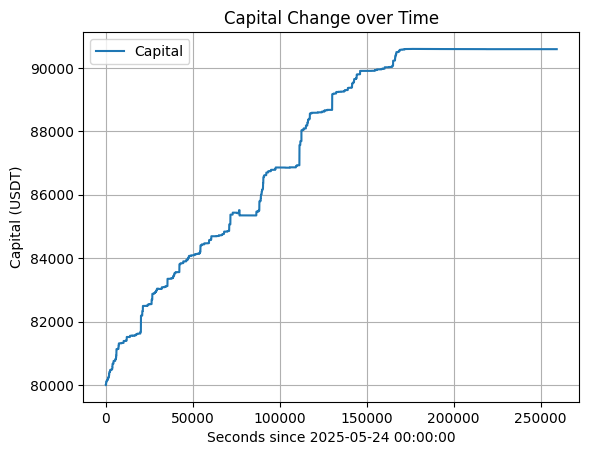

Testing parameters: M=1.0, N=1.0, g=1.5, j=0.5, l=7.5, C=0.0005
Num of transactions:  85
Final Capital: 80070.73
Total return: 0.0884%
Sharpe Ratio Seconds: 0.0033
Sharpe Ratio Minutes: 0.0252
Sharpe Ratio Hours: 0.1488
Max Drawdown: -0.0002%
Win Rate: 96.4706%
Total Trading Costs: 426.47


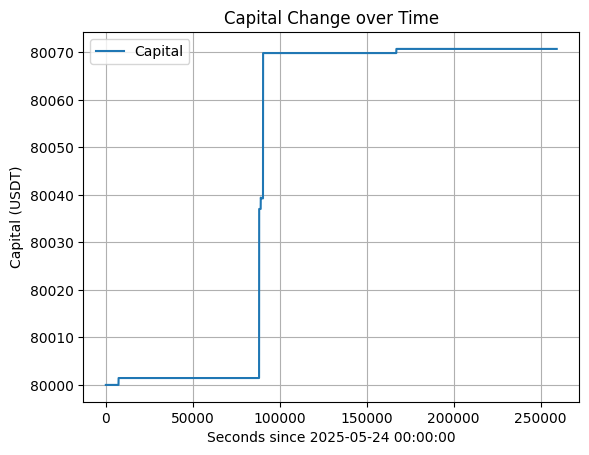

Testing parameters: M=21.0, N=11.0, g=2.0, j=1.0, l=7.5, C=0.0
Num of transactions:  13430
Final Capital: 80321.30
Total return: 0.4016%
Sharpe Ratio Seconds: 0.0005
Sharpe Ratio Minutes: 0.0039
Sharpe Ratio Hours: 0.0346
Max Drawdown: -1.1152%
Win Rate: 51.7126%
Total Trading Costs: 0.00


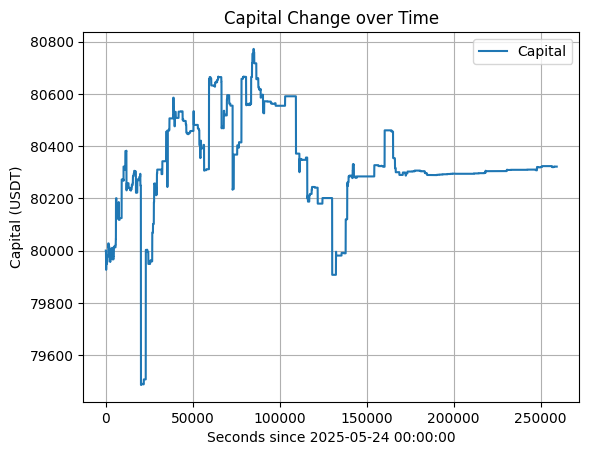

Testing parameters: M=11.0, N=11.0, g=1.5, j=0.0, l=5.0, C=0.0001
Num of transactions:  12814
Final Capital: 73515.79
Total return: -8.1053%
Sharpe Ratio Seconds: -0.0072
Sharpe Ratio Minutes: -0.0557
Sharpe Ratio Hours: -0.3913
Max Drawdown: -8.1053%
Win Rate: 31.3953%
Total Trading Costs: 12983.81


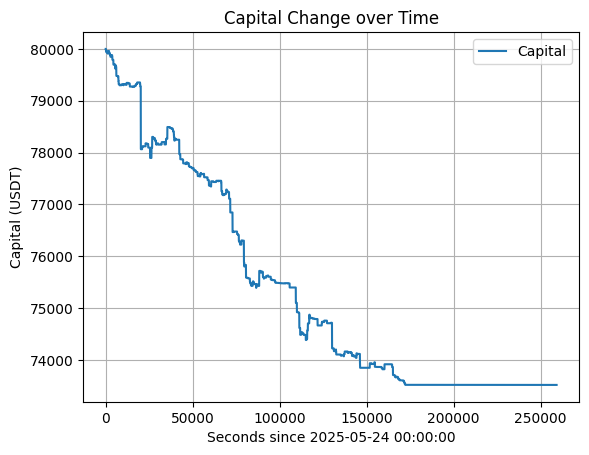

Testing parameters: M=21.0, N=11.0, g=2.0, j=0.0, l=10.0, C=0.0005
Num of transactions:  705
Final Capital: 77082.33
Total return: -3.6471%
Sharpe Ratio Seconds: -0.0055
Sharpe Ratio Minutes: -0.0427
Sharpe Ratio Hours: -0.3157
Max Drawdown: -3.6471%
Win Rate: 1.4184%
Total Trading Costs: 3550.60


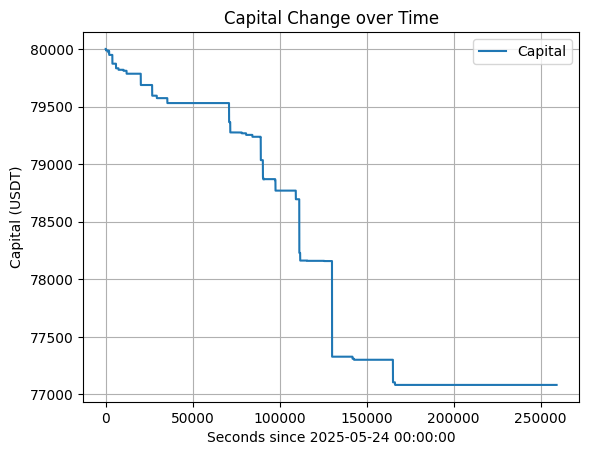

Testing parameters: M=21.0, N=11.0, g=2.0, j=0.0, l=10.0, C=0.001
Num of transactions:  25
Final Capital: 79813.04
Total return: -0.2337%
Sharpe Ratio Seconds: -0.0029
Sharpe Ratio Minutes: -0.0230
Sharpe Ratio Hours: -0.1238
Max Drawdown: -0.2337%
Win Rate: 0.0000%
Total Trading Costs: 248.99


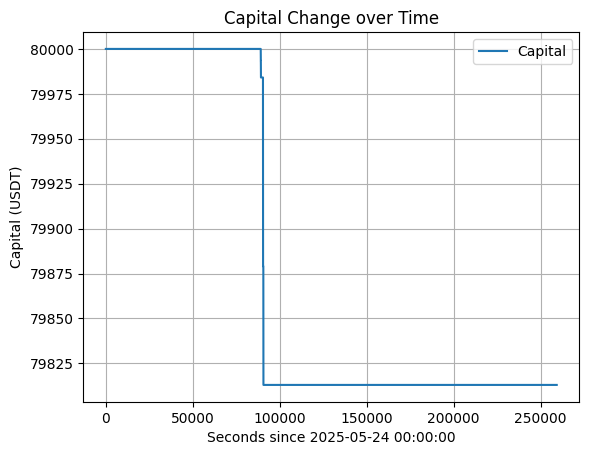

In [56]:
top = grid_search_aggressive.sort_values(by='final_capital', ascending=False).groupby('C').head(1).sort_values(by=['C','final_capital'], ascending=[True, False])
worst = grid_search_aggressive.sort_values(by='final_capital', ascending=False).groupby('C').tail(1).sort_values(by=['C','final_capital'], ascending=[True, True])

to_check = pd.concat([top, worst])
to_check = to_check.loc[to_check['num_transactions']!=0]

for index, row in to_check.iterrows():
    M, N, g, j, l, C, _, _ = row.tolist()

    transactions = simulate_aggressive_trading(M, N, g, j, l)

    transactions['trade'] = 1
    transactions['potential_trading_cost'] = C * transactions['potential_trading_cost_mult']
    transactions.loc[(transactions['potential_pnl'] < transactions['potential_trading_cost']), 'trade'] = 0
    transactions['trading_cost'] = C * transactions['trading_cost_mult']
    transactions['actual_pnl'] = (transactions['pnl'] - transactions['trading_cost']) * transactions['trade']

    num_transactions = transactions['trade'].sum()
    total_trading_costs = (transactions['trading_cost'] * transactions['trade']).sum()

    win_rate = (transactions['actual_pnl'] > 0).sum() / num_transactions

    transactions = transactions.groupby('seconds')['actual_pnl'].sum().reset_index()

    transactions = transactions.set_index('seconds').reindex(spreads_df['seconds'].tolist()).reset_index()
    transactions['actual_pnl'] = transactions['actual_pnl'].fillna(0)
    transactions['cumulative_pnl'] = transactions['actual_pnl'].cumsum()
    transactions['final_capital'] = initial_capital + transactions['cumulative_pnl']

    # Calculate total return
    transactions['ret_sec'] = (transactions['final_capital'].pct_change()).fillna(0)
    transactions['ret_min'] = ((transactions['final_capital'] - transactions['final_capital'].shift(61)) / transactions['final_capital'].shift(61)).fillna(0)
    transactions['ret_hour'] = ((transactions['final_capital'] - transactions['final_capital'].shift(3601)) / transactions['final_capital'].shift(3601)).fillna(0)

    max_drawdown = ((transactions['final_capital'] - transactions['final_capital'].cummax()) / transactions['final_capital'].cummax()).min()

    sharpe_sec = transactions['ret_sec'].mean() / transactions['ret_sec'].std()
    sharpe_min = transactions['ret_min'].mean() / transactions['ret_min'].std()
    sharpe_hour = transactions['ret_hour'].mean() / transactions['ret_hour'].std()

    total_return = transactions['cumulative_pnl'].iloc[-1] / initial_capital

    print(f'Testing parameters: M={M}, N={N}, g={g}, j={j}, l={l}, C={C}')
    print(f'Num of transactions: ', num_transactions)
    print(f'Final Capital: {transactions['final_capital'].iloc[-1]:.2f}')
    print(f'Total return: {total_return*100:.4f}%')
    print(f'Sharpe Ratio Seconds: {sharpe_sec:.4f}')
    print(f'Sharpe Ratio Minutes: {sharpe_min:.4f}')
    print(f'Sharpe Ratio Hours: {sharpe_hour:.4f}')
    print(f'Max Drawdown: {max_drawdown*100:.4f}%')
    print(f'Win Rate: {win_rate*100:.4f}%')
    print(f'Total Trading Costs: {total_trading_costs:.2f}')

    plt.plot(transactions['seconds'], transactions['final_capital'], label='Capital')
    plt.xlabel('Seconds since ' + str(start_time))
    plt.ylabel('Capital (USDT)')
    plt.title('Capital Change over Time')
    plt.legend()
    plt.grid()
    plt.show()
